# Face Recognition #6

- We are using: Ubble dataset

We have used during the computation of the FAR and TAR only the encodings that have been previously generated in order to speed up the execution.
Each person is described by a vector that contains a certain numbero of  encodings generated from images among all the ones available for a certain person in a video.


##Basic import

In [0]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/PRIM/'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

!pip install face_recognition

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import time
import pdb
import numpy as np
import random
import csv

print(dlib.DLIB_USE_CUDA)

True


In [0]:
#os.listdir(root_path + 'face_videos/face_videos')

## Creating new encodings

In [0]:
def createEncodings(dataset_vector, name , detection = 'cnn'):

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    '''
    We're going to take only a limit number of images to create the encodings.
    We'll take a random sample over all the images of a person and in particular
    '''
    #num = 50
    if len(dataset_vector )<= 0:
      print("AN ERROR OCCURRED FOR ",name)
      return

    #images = random.choices(dataset_vector, k = num, )

    images = dataset_vector#create the encodings for each frame in the video --> it will take a loooot of time to do all the videos

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []
    # loop over the image paths
    for image in images:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection)

        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)
            
    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings..." + name)
    data = {"encodings": knownEncodings, "names": knownNames}
    file_name = root_path + "/encodings_face_videos/" + name + '.pkl'
    
    print(len(knownEncodings))

    f = open(file_name, "wb")
    f.write(pickle.dumps(data))
    f.close()

In [0]:
def readFrames(path):
  
  video = cv2.VideoCapture(path)
  frames = []
  while(1):
      ret, frame = video.read()
      if ret == True:
        frames.append(frame)
      else:
          break
  return frames

In [0]:
base_path = root_path + 'face_videos/face_videos/'

In [0]:
videos = os.listdir(base_path)
global_start = time.time()
count = 0
for video_name in videos:
  start = time.time()
  #frames = readFrames(base_path + video_name)#remove the comment if you neeed to train new encodings
  #createEncodings(frames,video_name)
  end = time.time()
  print('Time_enc:', end-start)
  print(count)
  count += 1

global_end = time.time()
print('Total time:', global_end-global_start)

## Code for test

In [0]:
def faceRecognitionENC(encodings_1, encodings_2, detection='cnn', show=False, tolerance = 0.6):
    '''
    New version it only works with already made encodings
    encodings_1: single encoding of the person we want to recognize
    encodings_2: encodings of the person of which we know the name
    '''
    start = time.time()


    data = encodings_2


    # initialize the list of names for each face detected
    names = []
    
    # attempt to match each encoding to our known encodings

    matches = face_recognition.compare_faces(data["encodings"],encodings_1, tolerance= tolerance)
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      # Use the known face with the smallest distance to the new face 
      #this can help if in the video to recognize there is more than one person
      face_distances = face_recognition.face_distance(data["encodings"], encodings_1)
      best_match_index = np.argmin(face_distances)
      if matches[best_match_index]:
          name = data["names"][best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)
    
    return names
    
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data
    

In [0]:
import json
#code to retrieve the real name starting from the rec name
with open( root_path +'labelled_videos.json') as json_file:
  data = json.load(json_file)

def readTrueName(rec_name):
  
  for real_name in data:
    if rec_name in data[real_name]:
      return real_name
  return "unknown"

Two person are recognized as the same when:<br>
$percentageTrue > threshold$

Two early stopping condition are added:
- if after *minFrames* *percentageTrue > threshold* return *True*
-- if after *minFrames* *percentageFalse > 0.5* return *False*

In [0]:
def faceRecOnENC(encoding_path, encodings, correct_person,test_person, detection='cnn', min_threshold = 0.85, 
                    min_frames_to_compare = 30 ,
                    show=False, tolerance = 0.6):
    
    encodings_to_compare = encodingsRead(encoding_path)
    encodings_to_compare = encodings_to_compare["encodings"]#encoding of a different person

    

    start = time.time()

    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0

    # grab the paths to the input images in our dataset
    #print("[INFO] Recognizing faces...")
    #total_frames = len(encodings_to_compare)
    #print("[INFO] elements:", total_frames)

    #we had some cases where no faces where recognised
    if len(encodings_to_compare) <= 0:
        return False, 0, 0, 0
    
    if   len(encodings_to_compare) > global_number_test_enc:   
      encodings_to_compare = random.choices(encodings_to_compare , k = global_number_test_enc )#we took some random encoding between all the ones if we have a lot of encodings


    # loop over the encodings
    for enc in encodings_to_compare:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        
      person = faceRecognitionENC(enc, encodings, detection='cnn', show=show, tolerance = tolerance)
      analysed_frames += 1

      person = readTrueName(person[0])

      if(person == correct_person):#recognised

        if (correct_person == test_person): #correctly recognised
          correct_frames+=1 #true positive
        
        else:#wrongly recognised
          negative_frames += 1 #false positive

      else:#not recognized
        neutrum_frames += 1
          

      correct_rate = correct_frames/analysed_frames
      neutrum_rate = neutrum_frames/analysed_frames
      negative_rate = negative_frames/analysed_frames

      if (analysed_frames >= min_frames_to_compare): # ex 30fps --> 30 frames = 1 second  ---early stopping
        if (correct_frames + negative_frames)/analysed_frames > min_threshold:#ex 85% of the frames are recognised
          return True,correct_rate, neutrum_rate, negative_rate
        
        else:
          if neutrum_frames/analysed_frames > 0.5:#early stopping for the negative 
            return False,correct_rate, neutrum_rate, negative_rate


    #for end --> if we don't have so many frames

    if (correct_frames + negative_frames)/ analysed_frames > min_threshold:#ex 85% of the frames are recognised
      return True,correct_rate, neutrum_rate, negative_rate
    else:
      return False,correct_rate, neutrum_rate, negative_rate

In [0]:
encodings_folder = root_path + "/encodings_face_videos/"
test_path = encodings_folder #same we use only encodings

The Test compare the encodings of one person with the different encodings of the same one in order to compute the Tar only.

In [0]:
def performTestENC(min_v=0, max_v=1000, threshold=0.85, log=False, tolerance = 0.6):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    #pdb.set_trace()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    log_folder_base = 'logs_' + str(tolerance) + '_'+str(global_number_enc)+'/'
    
    if( log == True):
      log_folder = log_folder_base + 'T/'
      try:
          os.mkdir(root_path + '/logs#6/' + log_folder_base)
          os.mkdir(root_path + '/logs#6/' + log_folder)
      except FileExistsError:
          print('Already existing folder')
      logfile = open(root_path + '/logs#6/' + log_folder + "log" + str(min_v) + "-" + str(max_v) + ".txt", "w")

    for encoding in enc_list:
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding

        start_2 = time.time()

        curr_encoding = encodingsRead(encoding_path)
        
        real_name_curr_encoding = readTrueName(enc_name)
        
        #there are some people that don't have a label
        if (real_name_curr_encoding == "unknown"):
          continue


        print('[ENC] Using encoding:', enc_name)
        
        
        if   len(curr_encoding) >= global_number_enc:
          curr_encoding = random.choices(curr_encoding , k = global_number_enc)#we took some random encoding between all the ones if we have a lot of encodings
        
        
        for person in test_dir:
            
            if ( enc_name == person[0:len(person)-4]):#removing '.pkl' from name 
              continue

            test_enc = test_path + person            
            person = person[0:len(person)-4]
            
           
            
            real_name_test_encoding = readTrueName(person)

            if (real_name_test_encoding == "unknown"):#we have some encodings with no label
              continue
            
            if (real_name_test_encoding != real_name_curr_encoding ):#we want to compute only the encoding with the same person
              continue
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnENC(test_enc, curr_encoding, real_name_curr_encoding,real_name_test_encoding, min_threshold=threshold, show=False,tolerance = tolerance)
            
            if(log== True):
                line = person + " " + str(0) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
        
        end_2 = time.time()
        


        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    if( log == True):
      logfile.close()
    return

The CrossedTest compare the encodings of one person with all the other encodings (same person or not)  in order to compute later Far and Tar.
Here each person is compared with all the other except that with himself.


In [0]:
def performCrossedTestENC(min_v=0, max_v=1000, threshold=0.85, log=False, tolerance = 0.6):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
 
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)

    log_folder_base = 'logs_' + str(tolerance) + '_'+str(global_number_enc)+'/'


    for encoding in enc_list:
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        n_test = 0
        n_correct = 0
        
        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)

        real_name_curr_encoding = readTrueName(enc_name)
        
        #there are some people that don't have a label
        if (real_name_curr_encoding == "unknown"):
          continue

        print('[ENC] Using encoding:', enc_name)

        if  len(curr_encoding) > global_number_enc:
          curr_encoding = random.choices(curr_encoding , k = global_number_enc)#we took some random encoding between all the ones if we have a lot of encodings
        
        if( log == True):
          log_folder = log_folder_base + 'F/'
          try:
              os.mkdir(root_path + '/logs#6/' + log_folder_base)
              os.mkdir(root_path + '/logs#6/' + log_folder)
          except FileExistsError:
              print('Already existing folder')

          logfile = open(root_path + '/logs#6/' + log_folder + "log_" + enc_name + ".txt", "w")

        
        for person in test_dir:
            
            if ( enc_name == person[0:len(person)-4]):#removing '.pkl' from name 
              continue

            test_enc = test_path + person            
            person = person[0:len(person)-4]
            
            print('Testing on test encoding:', person)
            
            real_name_test_encoding = readTrueName(person)

            if (real_name_test_encoding == "unknown"):
              continue

            # test the encodings of testset               
            v, a, b, c = faceRecOnENC(test_enc, curr_encoding, real_name_curr_encoding,real_name_test_encoding, min_threshold=threshold, show=False,tolerance = tolerance)
            
            if(log== True):
                line = person + " " + str(0) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
                #print(line)
            if( v == True):
                n_correct += 1

        if(log == True):
            logfile.close()
        
        end_2 = time.time()
        


        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    return

## Code for Statistics

In [0]:
from sklearn.metrics import roc_curve, auc

def showStats(folder,tolerance):

  print("##############")
  print("TOLERANCE",tolerance)
  print("#############")


  FAR_path = folder+'/F/'

  files = os.listdir(FAR_path)


  values = [0.85]
  confirmed_rate = np.zeros(len(values))
  i = 0

  for thr in values:
      total_files = 0
      recognized = 0
      notdetected = 0
      wrong = 0
      wrong_confirmed = 0
      wrong_confirmed2 = 0
      wrong_confirmed3 = 0
      wrong_confirmed4 = 0

      global_pos_count = 0
      global_pos = 0
      global_neg_count = 0
      global_neg = 0

      ####
      one_wrong_rec = 0
      persons = 0
      for f in files:
          if( f.startswith('log') == True):
              filev = open(FAR_path + f, "r")
              vector = f.split('_')[1].split(".")[0]
              correct_person = readTrueName(vector + '.webm')
              lines = filev.readlines()
              persons += 1
              for line in lines: 
                  
                  name = line.split(' ')[0]
                  total_files += 1

                  rec_flag = line.split(' ')[2]
                  #pdb.set_trace()

                  if(readTrueName(name) == correct_person):#same person
                      
                      if rec_flag == 'True':#acces granted correctly
                        global_pos +=1
                      
                      global_pos_count+=1
                  
                  else:#non sono la stessa persona
                      if rec_flag == 'True':#wrong acces granted 
                        global_neg +=1
                      
                      global_neg_count+=1

                  rec_percentage = float(line.split(' ')[3])
                  notdec_percentage = float(line.split(' ')[4])
                  notrec_percentage = float(line.split(' ')[5])

                  recognized = recognized + rec_percentage
                  notdetected = notdetected + notdec_percentage
                  wrong = wrong + notrec_percentage

                  if(notrec_percentage > thr):
                      wrong_confirmed = wrong_confirmed + 1
      
      if(total_files == 0):
          total_files = 1
      confirmed_rate[i] = wrong_confirmed / total_files
      wrong_confirmed = 0
      i = i +1

  ## equal for each iteration
  positive = recognized / total_files 
  undetected = notdetected / total_files
  negative = wrong / total_files

  wrong_rec_on_persons = one_wrong_rec / (persons-1)

  #----------------------------------------------------------------------------#
  
  ## WRONG ONES WHERE ASSIGNED TO THE PERSON EVEN IF HE WASN'T

  labels = ['Correct', 'NotRecognized', 'Wrong']
  colors = ['Blue', 'Yellow', 'Orange']
  sizes1 = [positive, undetected, negative]


  plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
  plt.title('Recognition average over all the images')
  plt.legend()
  plt.show()
  print('Percentage of overall images that were correctly not recognized:', undetected)
  print('\n\n')
  #--------------------------------------------------------------------------------------------#
  
  cfr = global_neg/global_neg_count
  
  labels = ['Wrongly Confirmed', 'Correclty Not Confirmed']
  colors = ['Red','Green']
  sizes1 = [cfr, (1 - cfr)]



  plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
  plt.title('Confirmation percentage using our algorithm metrics')
  plt.show()
  print('Percentage of TRR ' 'is', 1-cfr)
  print('Percentage of FAR ' 'is', cfr)
  print('\n\n')
  #--------------------------------------------------------------------------------------------------------------------------#
  '''
  TAR_path = folder+'/T/'

  files = os.listdir(TAR_path)
  confirmed_rateT = np.zeros(len(values))

  for thr in values:
      global_pos_count = 0
      global_pos = 0
      for f in files:
          if( f.startswith('log') == True):
              filev = open(TAR_path + f, "r")
              lines = filev.readlines()
              for line in lines:
                  total_files += 1

                  rec_flag = line.split(' ')[2]
                  if rec_flag == 'True':
                    global_pos +=1

                  global_pos_count += 1

    
  print(global_pos,global_pos_count)
  '''
  #----------------------------------------------------------------------------#
  cfr = global_pos/global_pos_count
  
  labels = ['Correctly Confirmed', 'Wrongly Not Confirmed']
  colors = ['Green', 'Red']
  sizes1 = [cfr, (1 - cfr)]


  plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
  plt.title('Confirmation percentage using our algorithm metrics')
  plt.show()
  print('Percentage of TAR ' 'is', cfr)
  print('Percentage of FRR ' 'is', 1-cfr)
  #--------------------------------------------------------------------------------------------------------------------------#


## Run Experiments
We are going now to compare each person with all the other videos so both himselfand different one.
At the end we use the log to compute Tar,Trr,Far and Frr 

### 20 encodings per person, 4 different tolerances and threshold = 0.85

In [0]:
encodings_folder = root_path + "/encodings_face_videos_20/"
test_path = encodings_folder #same we use only encodings

global_number_enc = 20 #number of encoding taken for each known person
global_number_test_enc = 20 #number of encoding taken for each unknown person

In [0]:
performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.3,log= True, threshold=0.85)

##############
TOLERANCE 0.3
#############


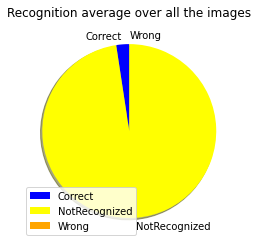

Percentage of overall images that were correctly not recognized: 0.9759135777047758





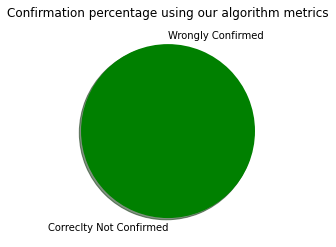

Percentage of TRR is 1.0
Percentage of FAR is 0.0





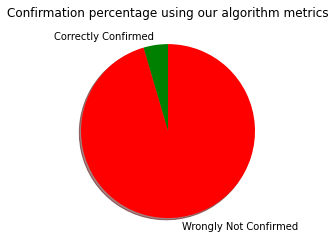

Percentage of TAR is 0.04543848491272701
Percentage of FRR is 0.9545615150872729


In [0]:
folder = root_path +"logs#6/logs_0.3_20"
showStats(folder,0.3)

In [0]:
performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.4,log= True, threshold=0.85)

##############
TOLERANCE 0.4
#############


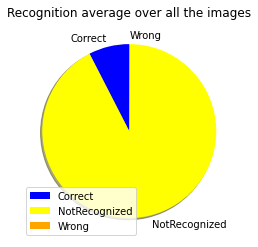

Percentage of overall images that were correctly not recognized: 0.9238129816067356





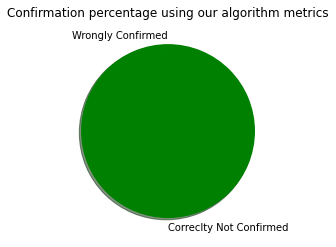

Percentage of TRR is 0.9999439084586045
Percentage of FAR is 5.609154139555755e-05





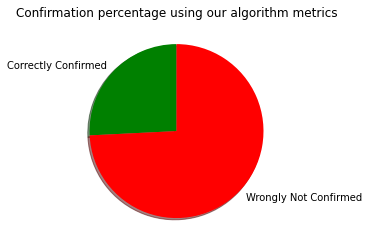

Percentage of TAR is 0.25790394188080185
Percentage of FRR is 0.7420960581191982


In [0]:
folder = root_path +"logs#6/logs_0.4_20"
showStats(folder,0.4)

In [0]:
performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.5,log= True, threshold=0.85)

##############
TOLERANCE 0.5
#############


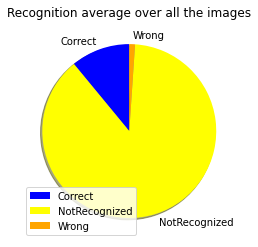

Percentage of overall images that were correctly not recognized: 0.8795868689403494





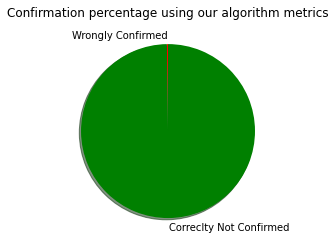

Percentage of TRR is 0.9978236481938524
Percentage of FAR is 0.002176351806147633





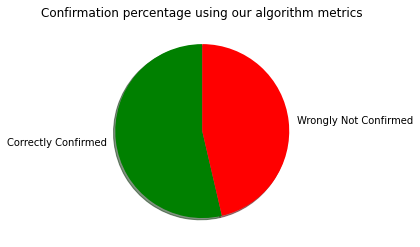

Percentage of TAR is 0.536324498856451
Percentage of FRR is 0.46367550114354905


In [0]:
folder = root_path +"logs#6/logs_0.5_20"
showStats(folder,0.5)

In [0]:
performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.55,log= True, threshold=0.85)

##############
TOLERANCE 0.55
#############


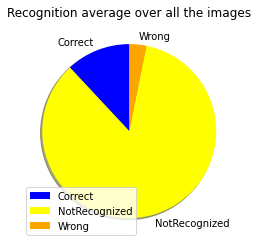

Percentage of overall images that were correctly not recognized: 0.8489178188288347





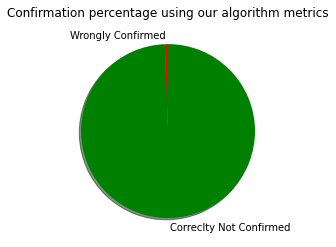

Percentage of TRR is 0.9939421135292797
Percentage of FAR is 0.006057886470720216





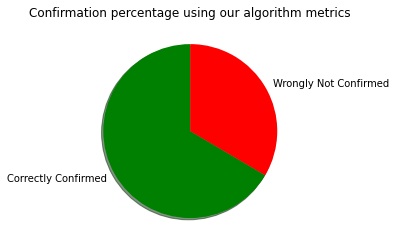

Percentage of TAR is 0.6652092022063769
Percentage of FRR is 0.3347907977936231


In [0]:
folder = root_path +"logs#6/logs_0.55_20"
showStats(folder,0.55)

### 50 encodings per person ,2 different tolerances and threshold = 0.85

In [0]:
encodings_folder = root_path + "/encodings_face_videos_50/"
test_path = encodings_folder #same we use only encodings

global_number_enc = 50 #number of encoding taken for each known person
global_number_test_enc = 50 #number of encoding taken for each unknown person

In [0]:

performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.4,log= True, threshold=0.85)

##############
TOLERANCE 0.4
#############


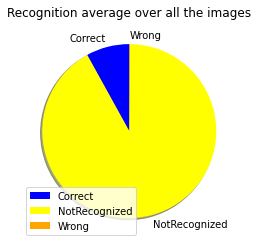

Percentage of overall images that were correctly not recognized: 0.9185304361821522





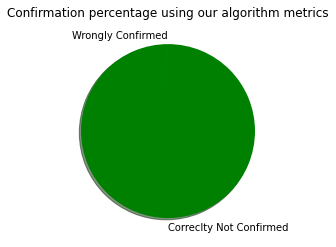

Percentage of TRR is 0.9998653803006506
Percentage of FAR is 0.00013461969934933812





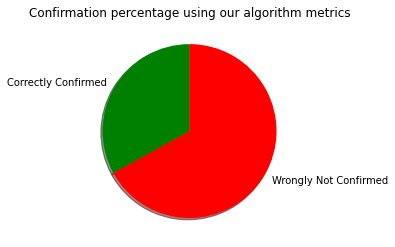

Percentage of TAR is 0.3301493340508543
Percentage of FRR is 0.6698506659491457


In [0]:
folder = root_path +"logs#6/logs_0.4_50"
showStats(folder,0.4)

In [0]:
performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.5,log= True, threshold=0.85)

##############
TOLERANCE 0.5
#############


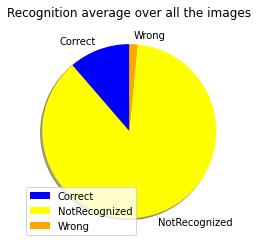

Percentage of overall images that were correctly not recognized: 0.8716238897611355





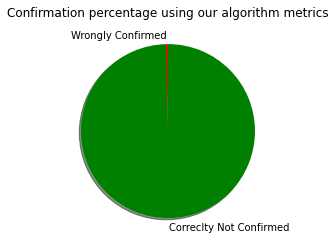

Percentage of TRR is 0.9964662328920799
Percentage of FAR is 0.0035337671079201257





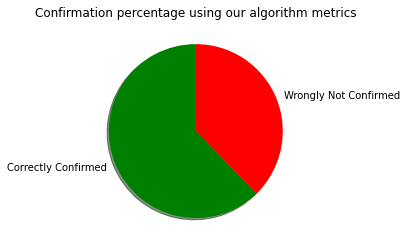

Percentage of TAR is 0.6230996905690838
Percentage of FRR is 0.37690030943091624


In [0]:
folder = root_path +"logs#6/logs_0.5_50"
showStats(folder,0.5)

### 100 encodings per person ,2 different tolerances and threshold = 0.85

In [0]:
encodings_folder = root_path + "/encodings_face_videos/"
test_path = encodings_folder #same we use only encodings

global_number_enc = 100 #number of encoding taken for each known person
global_number_test_enc = 100 #number of encoding taken for each unknown person

In [0]:
performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.4,log= True, threshold=0.85)

##############
TOLERANCE 0.4
#############


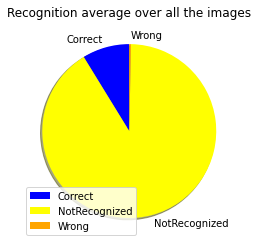

Percentage of overall images that were correctly not recognized: 0.9091749015617223





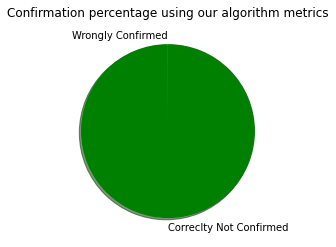

Percentage of TRR is 0.9994390845860445
Percentage of FAR is 0.0005609154139555755





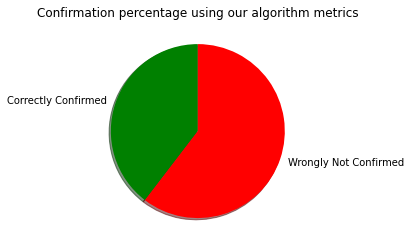

Percentage of TAR is 0.3960043051257904
Percentage of FRR is 0.6039956948742096


In [0]:
folder = root_path +"logs#6/logs_0.4_100"
showStats(folder,0.4)

In [0]:
performCrossedTestENC(min_v=0, max_v=1000 ,tolerance = 0.5,log= True, threshold=0.85)

##############
TOLERANCE 0.5
#############


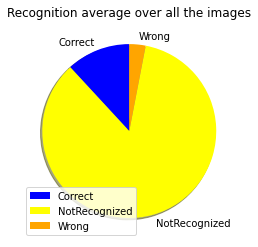

Percentage of overall images that were correctly not recognized: 0.8510349978423395





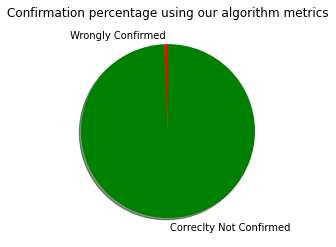

Percentage of TRR is 0.9935382544312318
Percentage of FAR is 0.00646174556876823





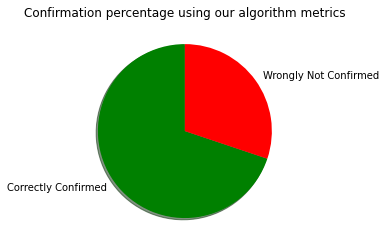

Percentage of TAR is 0.6985066594914571
Percentage of FRR is 0.30149334050854293


In [0]:
folder = root_path +"logs#6/logs_0.5_100"
showStats(folder,0.5)